Exploration of wine reviews data and text based logistic regression modeling 
Available on Gihub: https://github.com/carkar7/Classifying-wine-type-based-on-wine-reviews

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split
%matplotlib inline

# Reading and Cleaning

In [2]:
data = pd.read_csv('OSX_DS_assignment.csv')
data.head(5)

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,@kerinokeefe,Italy,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Nicosia,White Blend
1,@vossroger,Portugal,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Quinta dos Avidagos,Portuguese Red
2,@paulgwine,US,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Rainstorm,Pinot Gris
3,NaN,US,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,St. Julian,Riesling
4,@paulgwine,US,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks,Pinot Noir


## Lots of duplicates
There are a lot of duplicates in this data. Oddly enough, I noticed that simply running data.drop_duplicates() did not remove all duplicates, which is the result of some columns between the duplicated rows differeing. Nevertheless, the fact that the "Description" columns were identical was a dead giveaway that these were not a different reviews. 

In [3]:
data[data.duplicated('review_description',keep=False)].sort_values('review_description').head(5)

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
53615,@wawinereport,US,Roza Ridge 2010 Malbec (Rattlesnake Hills),"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Roza Ridge,Malbec
36962,@wawinereport,US,Roza Ridge 2010 Malbec (Rattlesnake Hills),"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Roza Ridge,Malbec
57295,@wawinereport,US,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Ross Andrew,Rosé
95074,@wawinereport,US,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Ross Andrew,Rosé
80038,@vossroger,France,Château Lalande-Borie 2008 Barrel sample (Sai...,"87-89 Barrel sample. A pleasurable, perfumed w...",Barrel sample,88,NaN,Bordeaux,Saint-Julien,NaN,Château Lalande-Borie,Bordeaux-style Red Blend


I decided to drop all duplicates based on the description column alone and subsequently all missing price data:

In [4]:
data = data.drop_duplicates('review_description')
data = data[pd.notnull(data.price)]
data.shape

(88923, 12)

# Exploratory Analysis
Not surprisingly, there's a significant correlation between the cost of wine and its rating, namely theres an average $1.18  increase for every one point incrase in rating.

Pearson Correlation: (0.4157493612710554, 0.0)
                                 OLS Regression Results                                
Dep. Variable:                 points   R-squared (uncentered):                   0.429
Model:                            OLS   Adj. R-squared (uncentered):              0.429
Method:                 Least Squares   F-statistic:                          6.679e+04
Date:                Sun, 14 May 2023   Prob (F-statistic):                        0.00
Time:                        23:25:52   Log-Likelihood:                     -4.9997e+05
No. Observations:               88923   AIC:                                  9.999e+05
Df Residuals:                   88922   BIC:                                  9.999e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0

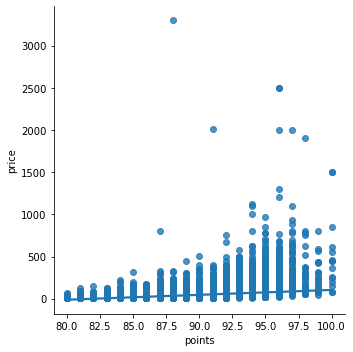

In [5]:
from scipy.stats import pearsonr
import statsmodels.api as sm
print("Pearson Correlation:", pearsonr(data.price, data.points))
print(sm.OLS(data.points, data.price).fit().summary())
sns.lmplot(y = 'price', x='points', data=data)


Plotting all the countries, there's some odd plots as a result of low sample size for certain countries.

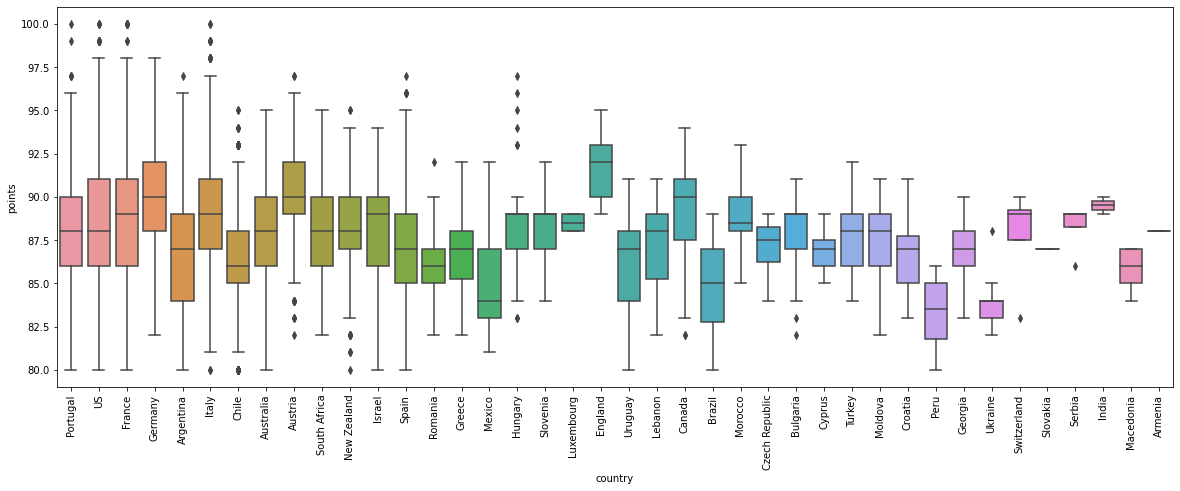

In [6]:
fig, ax = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='country',y='points', data=data, ax = ax)
plt.xticks(rotation = 90)
plt.show()

In [7]:
data.country.value_counts()[:17]

US              44371
France          14553
Italy            9094
Chile            3357
Portugal         3276
Spain            3114
Argentina        2946
Austria          1846
Germany          1757
New Zealand      1223
Australia        1192
South Africa      776
Israel            356
Canada            183
Greece            178
Bulgaria          109
Romania            84
Name: country, dtype: int64

After removing all countries with less than 100 observations, it appears that Germany, Austria, and Canada have the highest median scores(points). However, the distribution overall appears to be fairly uniform.

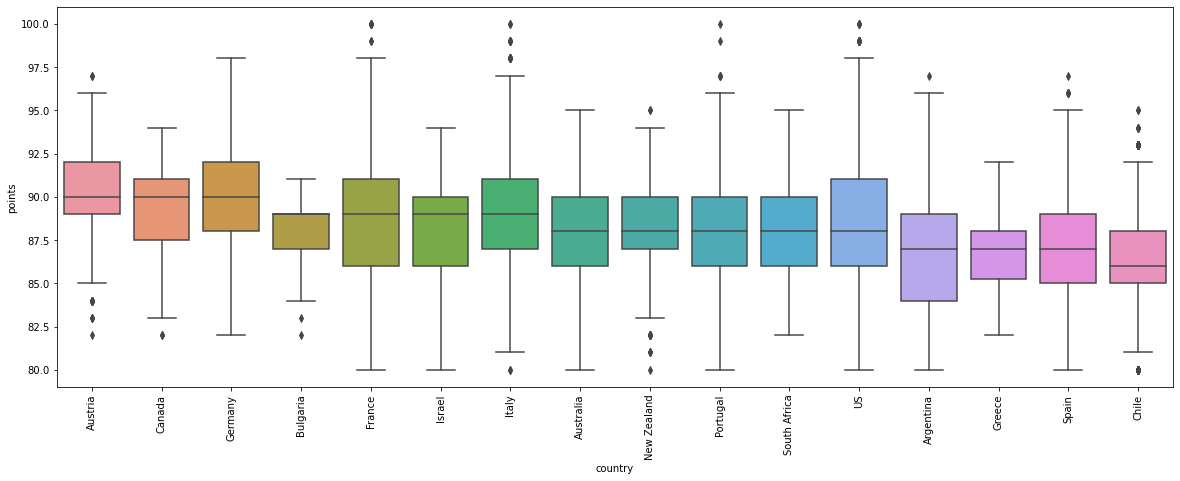

In [8]:
country=data.groupby('country').filter(lambda x: len(x) >100)
df2 = pd.DataFrame({col:vals['points'] for col,vals in country.groupby('country')})
meds = df2.median()
meds.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='country',y='points', data=country, order=meds.index, ax = ax)
plt.xticks(rotation = 90)

plt.show()

Below are the average wine prices sorted by median (highest to lowest) in order to evaluate price distortions due to outliers.

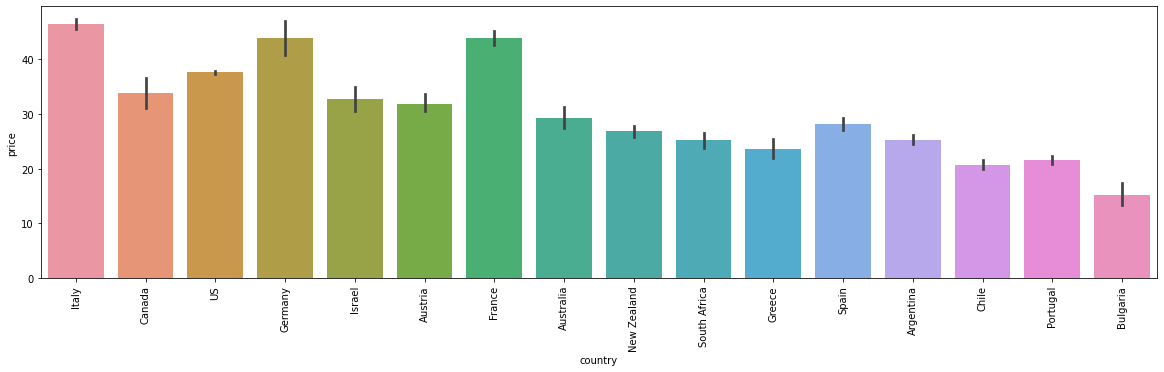

In [9]:
df3 = pd.DataFrame({col:vals['price'] for col,vals in country.groupby('country')})
meds2 = df3.median()
meds2.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize = (20,5))
chart = sns.barplot(x='country',y='price', data=country, order=meds2.index, ax = ax)
plt.xticks(rotation = 90)
plt.show()

In [10]:
# medians for the above barplot
print(meds2)

Italy           35.0
Canada          30.0
US              30.0
Germany         27.0
Israel          27.0
Austria         25.0
France          25.0
Australia       20.0
New Zealand     20.0
South Africa    20.0
Greece          19.0
Spain           18.0
Argentina       17.0
Chile           15.0
Portugal        15.0
Bulgaria        14.0
dtype: float64


There's a large variety of wines in the dataset (I never knew there was so many!) However, there's an exponential decline in the number of observations for each wine type, and since we'll be attempting to use these labels to classify our model, I'll be dropping any wine types with less than 200 observations, for the reason that I don't believe there's enough data in these buckets to generate an accuarte model for predicting their respective wine type

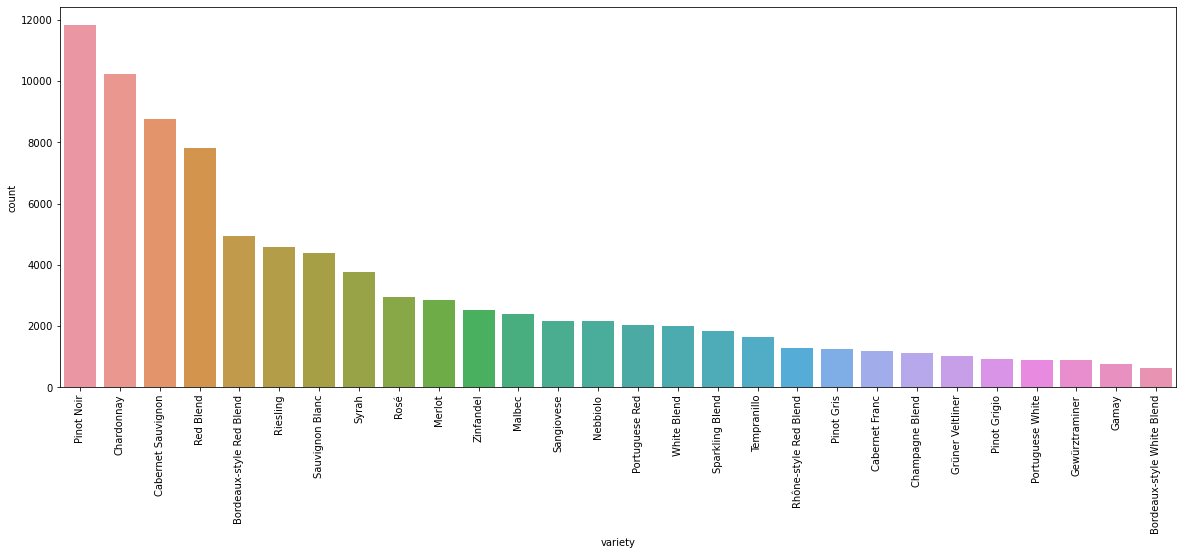

In [11]:
data = data.groupby('variety').filter(lambda x: len(x) >100)
list = data.variety.value_counts().index.tolist()
fig4, ax4 = plt.subplots(figsize = (20,7))
sns.countplot(x='variety', data=data, order = list, ax=ax4)
plt.xticks(rotation = 90)
plt.show()

Below is a boxplot chart containing all wine varieties (w/ >200 observations) and their respective point distributions. Sangiovese Grosso (never tried it) appears to have the highest median score of all wines. There are some interesting dips occuring after Champagne Blend, Shiraz, Cabernet Sauvignon (my favorite), and Nero d'Avola. Of interest is Merlot, which tends to have a large number of highly reviewed outliers. Despite these slight variations, overall the point distibution is basically uniform.

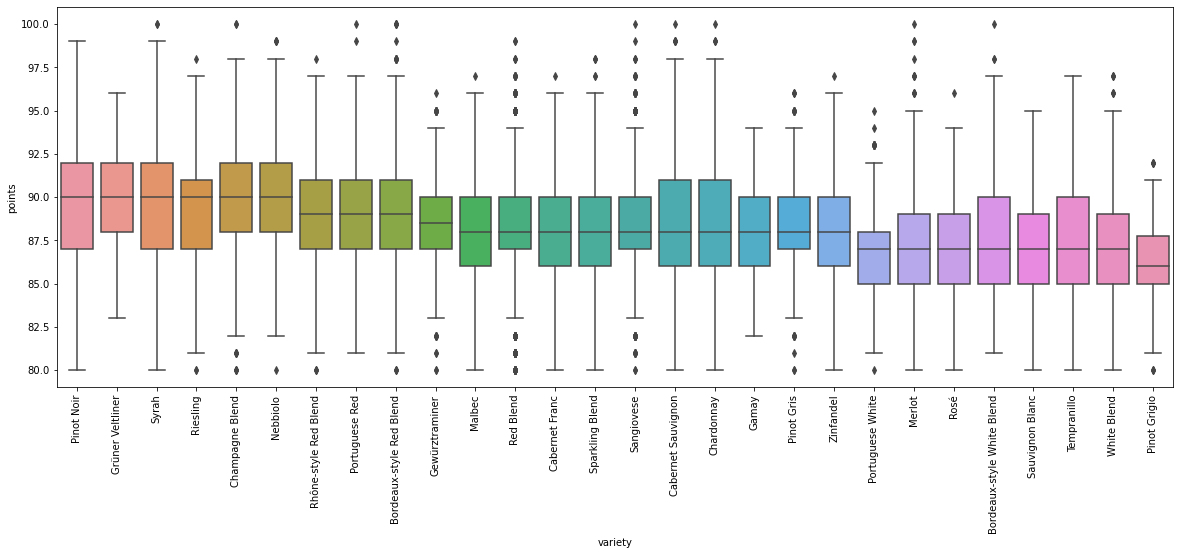

In [12]:
data = data.groupby('variety').filter(lambda x: len(x) >200)

df4 = pd.DataFrame({col:vals['points'] for col,vals in data.groupby('variety')})
meds3 = df4.median()
meds3.sort_values(ascending=False, inplace=True)

fig3, ax3 = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='variety',y='points', data=data, order=meds3.index, ax = ax3)
plt.xticks(rotation = 90)
plt.show()

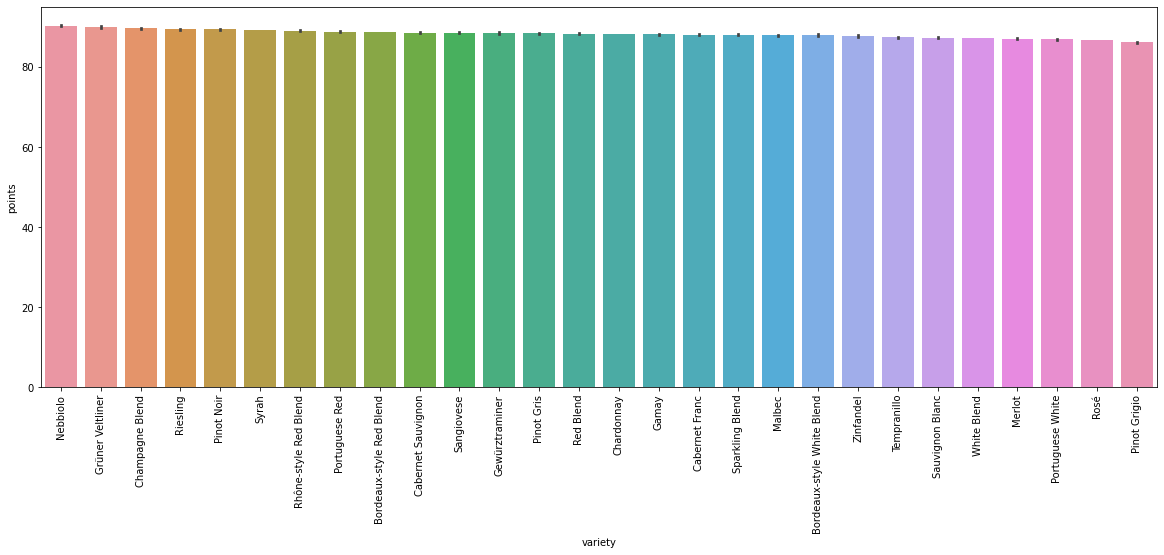

In [13]:
df5 = pd.DataFrame({col:vals['points'] for col,vals in data.groupby('variety')})
mean1 = df5.mean()
mean1.sort_values(ascending=False, inplace=True)

fig3, ax3 = plt.subplots(figsize = (20,7))
chart = sns.barplot(x='variety',y='points', data=data, order=mean1.index, ax = ax3)
plt.xticks(rotation = 90)
plt.show()

It's definitely not the same story when you look at price. There's clear variation in here, which may help in predicting the wine type.

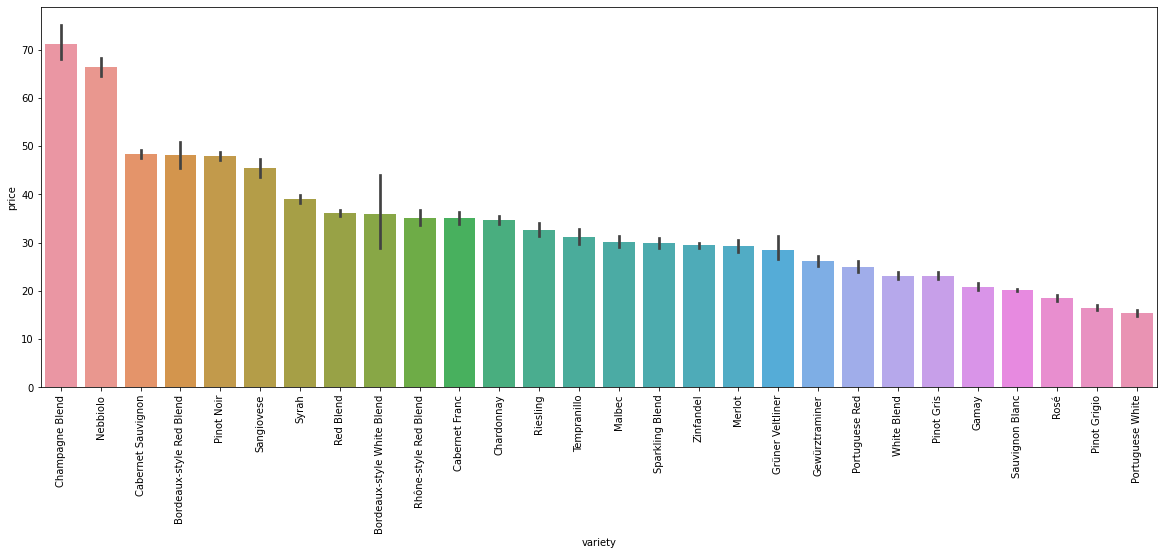

In [14]:
df6 = pd.DataFrame({col:vals['price'] for col,vals in data.groupby('variety')})
mean2 = df6.mean()
mean2.sort_values(ascending=False, inplace=True)

fig3, ax3 = plt.subplots(figsize = (20,7))
chart = sns.barplot(x='variety',y='price', data=data, order=mean2.index, ax = ax3)
plt.xticks(rotation = 90)
plt.show()

# Modeling: Logistic Regression


In [15]:
X = data.drop(['user_name','country','review_title','designation','points','province','region_1','region_2'], axis = 1)
y = data.variety

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(66692, 4) (22231, 4) (66692,) (22231,)


### The Label Occurs in the Desciption!
My first time around with this dataset, I was getting accuracy scores around 80% but something didn't feel right... 

If you read the descriptions, the reviewers often times say "Cabertnet", "Pinot", "Red", etc. in the review itself, and these words need to be taken off if the aim is to create a model that doesn't rely on the probability that a word in the description that matches the label. WIth that said, I included tokenized versions of the feature labels as parts of the stopwords used in analysis.

In [16]:
wine =data.variety.unique().tolist()
wine.sort()
wine[:10]

['Bordeaux-style Red Blend',
 'Bordeaux-style White Blend',
 'Cabernet Franc',
 'Cabernet Sauvignon',
 'Champagne Blend',
 'Chardonnay',
 'Gamay',
 'Gewürztraminer',
 'Grüner Veltliner',
 'Malbec']

In [17]:
output = set()
for x in data.variety:
    x = x.lower()
    x = x.split()
    for y in x:
        output.add(y)

variety_list =sorted(output)
variety_list[:10]


['blanc',
 'blend',
 'bordeaux-style',
 'cabernet',
 'champagne',
 'chardonnay',
 'franc',
 'gamay',
 'gewürztraminer',
 'grigio']

In [18]:
extras = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', 'cab',"%"]
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.update(variety_list)
stop.update(extras)
stop.update(['yourselves', 'mustn', 'hadn', 'because', 'is', 'will', 'few', '"', 'myself', 'whom', 'up', 'did', 'nor', 'while', 'sauvignon', 'barbera', 'our', 'which', "d'avola", 'sangiovese', 'it', 'were', 'we', 'am', 'port', 'a', 'weren', 'torrontés', 'of', 'hers', 'just', 'sparkling', 'yourself', 'you', 'in', 'where', 'not', 'doing', 'y', 'theirs', 'after', 'here', '.', "needn't", 'their', 'shiraz', "hasn't", 'or', 'corvina,', 'those', '(', 'over', 'being', 've', 'malbec', 'nebbiolo', 'gewürztraminer', ')', "don't", "aren't", 'grigio', 'each', 'further', 'then', 'bordeaux-style', 'some', 'down', 'wasn', "wouldn't", 'and', 'nero', 'such', "shan't", 'red', 'can', 'meritage', 'rhône-style', "you'd", 'again', 'no', "couldn't", 'this', 'ours', 'portuguese', 'if', 'into', 'needn', 'franc', 'above', 'have', 'at', 'd', '[', 'below', '!', 'between', 'herself', 't', 'albariño', 'aren', "weren't", '?', 'champagne', 'grüner', 'viognier', 'very', 'isn', 'merlot', 'blend', 'me', "hadn't", 'its', 'once', 'are', 'ain', 'been', 'to', "wasn't", 's', 'gris', 'only', "you'll", 'i', 'was', 'more', 'garnacha', 'yours', 'pinot', 'when', "didn't", 're', 'didn', 'syrah', 'how', 'them', 'that', 'until', 'chenin', 'him', "that'll", "doesn't", 'why', "mightn't", 'aglianico', 'chardonnay', 'own', 'verdejo', '}', 'against', 'doesn', "'", 'themselves', 'cabernet', "isn't", 'himself', 'moscato', ']', 'gamay', 'on', 'grosso', 'had', 'all', '%', 'your', 'off', 'grenache', 'riesling', 'but', 'glera', 'don', 'zinfandel', 'petite', 'couldn', "it's", 'an', 'most', 'by', 'who', 'll', 'for', 'o', 'mightn', 'her', 'under', 'too', 'out', 'any', 'wouldn', 'his', "shouldn't", 'both', 'tempranillo', 'carmenère', 'other', 'the', 'won', 'what', 'having', "should've", 'shan', 'with', 'rondinella,', 'm', "you've", 'now', 'she', 'during', 'before', 'they', 'blanc', ':', "she's", 'cab', 'should', 'from', "haven't", 'my', 'haven', 'shouldn', 'has', 'about', 'molinara', 'these', ',', 'does', 'through', '{', 'as', 'do', 'he', 'ma', "you're", 'so', 'noir', 'prosecco', 'be', 'veltliner', 'same', 'hasn', 'sirah', 'itself', 'there', 'rosé', ';', 'white', 'than', 'ourselves', "won't", "mustn't"])


### Features
The features being used in this model will be the wine price and it's description. 

In [19]:
from scipy.sparse import hstack

vect = CountVectorizer(stop_words = stop)
X_train_dtm = vect.fit_transform(X_train.review_description)
price = X_train.price.values[:,None]
X_train_dtm = hstack((X_train_dtm, price))
X_train_dtm

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['avola', 'bordeaux', 'corvina', 'rhône', 'rondinella', 'style'] not in stop_words.
  warnings.warn(


<66692x24311 sparse matrix of type '<class 'numpy.float64'>'
	with 1663353 stored elements in COOrdinate format>

In [20]:
X_test_dtm = vect.transform(X_test.review_description)
price_test = X_test.price.values[:,None]
X_test_dtm = hstack((X_test_dtm, price_test))
X_test_dtm

<22231x24311 sparse matrix of type '<class 'numpy.float64'>'
	with 551905 stored elements in COOrdinate format>

In [23]:
from sklearn.linear_model import LogisticRegression
models = {}
for z in wine:
    model = LogisticRegression()
    y = y_train
    model.fit(X_train_dtm, y)
    models[z] = model

testing_probs = pd.DataFrame(columns = wine)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyboardInterrupt: 

# Final Accuracy: 53%
There's definitely room for improvement, and I could include other features to see if accuracy increases, but for now I'll settle with this and grab a glass of wine for myself :)

In [22]:
for variety in wine:
    testing_probs[variety] = models[variety].predict_proba(X_test_dtm)[:,1]
    
predicted_wine = testing_probs.idxmax(axis=1)

comparison = pd.DataFrame({'actual':y_test.values, 'predicted':predicted_wine.values})   

from sklearn.metrics import accuracy_score
print('Accuracy Score:',accuracy_score(comparison.actual, comparison.predicted)*100,"%")
comparison.head(5)

NameError: name 'testing_probs' is not defined